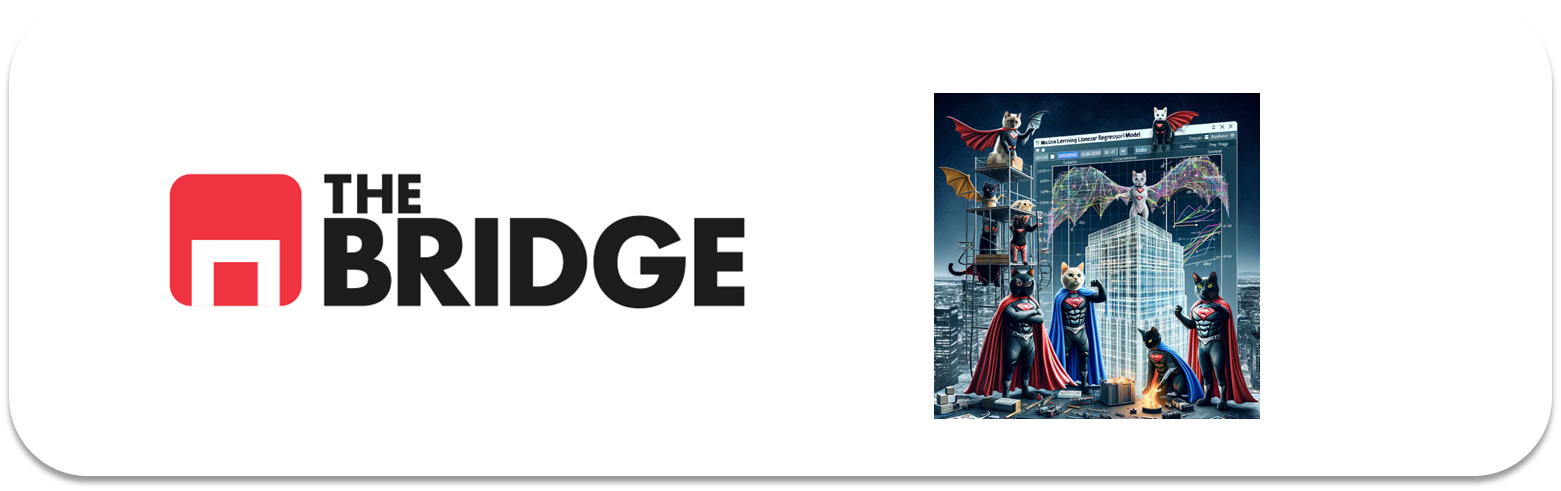

## Clasificación Multicategórica con Regresión Logística

### Entender el problema

Para mostrar la creación de un modelo multiclase y su evaluación vamos a tratar un problema en el que queremos detectar cuál es el sistema operativo de los usuarios que acceden a una dirección web específica (y que no es importante para el problema) en la que pasan un tiempo determinado, navegan a través de las páginas del site, realizan un conjunto de acciones y dejan una valoración de la misma. Encontrarás una variable "clase" que contiene el target, esta vez no tendrás que buscarlo, y que toma tres posibles valores en función del OS: Windows, Linux, Mac. 

Creemos ese modelo predictor a partir de una regresión logística.

### Preparación Datos: Primer vistazo

In [28]:
import pandas as pd
import numpy as np
from sklearn import linear_model
from sklearn import model_selection
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

In [29]:
df_os = pd.read_csv("data/usuarios_win_mac_lin.csv")

clases = {
    0: 'Windows',
    1: 'Linux',
    2: 'Mac'
}

df_os.head()

,duracion,paginas,acciones,valor,clase
0,7.0,2,4,8,2
1,21.0,2,6,6,2
2,57.0,2,4,4,2
3,101.0,3,6,12,2
4,109.0,2,6,12,2


In [30]:
df_os.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170 entries, 0 to 169
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   duracion  170 non-null    float64
 1   paginas   170 non-null    int64  
 2   acciones  170 non-null    int64  
 3   valor     170 non-null    int64  
 4   clase     170 non-null    int64  
dtypes: float64(1), int64(4)
memory usage: 6.8 KB


Mostramos el target, y su balanceo o desbalanceo

In [31]:
df_os.clase.value_counts(True)

clase
0    0.505882
2    0.258824
1    0.235294
Name: proportion, dtype: float64

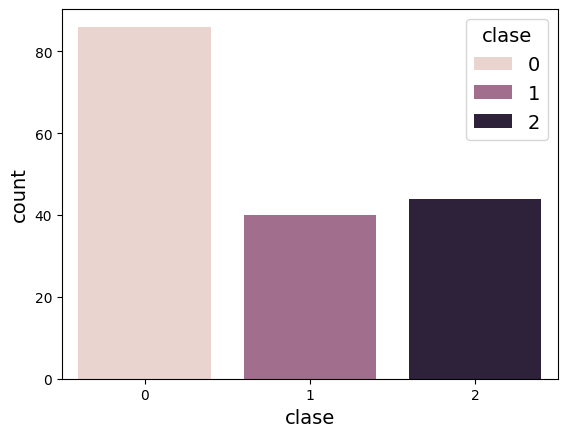

In [32]:
sns.countplot(x = "clase", data = df_os, hue = "clase");

Windows es el sistema dominante y habrá que tenerlo en cuenta a la hora de las medidas y tendríamos que tenerlo en cuenta a la hora de modelar pero lo veremos en sesiones posteriores.

Echamos un vistazo y sólo eso a la distribución de las variables contínuas (o sea casi todas) y nos fijamos en escala y figura

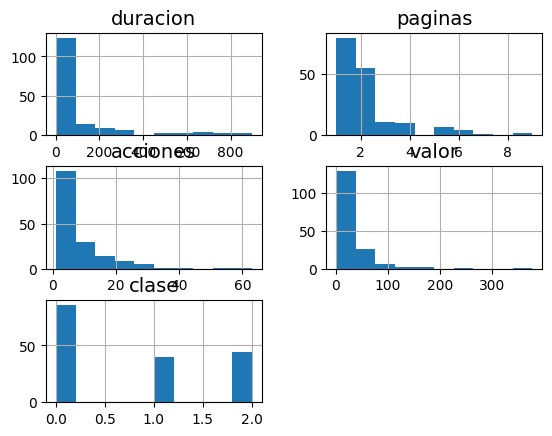

In [33]:
df_os.hist();

Tiene pinta de que vamos a tener que escalar y hacer alguna transformación para "normalizar" las distribuciones.

### Split

Son muy pocos datos (170) pero vamos a hacer el split igual para que vayamos cogiendo el hábito. Además estratificamos sobre el target (pero ojo esto es para hacer más limpio el ejercicio, por ejemplo porque suponemos que es algo que se va a mantener debido al marketshare de cada sistema operativo)

In [34]:
train_set, test_set = train_test_split(df_os, test_size= 0.2, stratify= df_os["clase"], random_state= 42)

In [35]:
train_set["clase"].value_counts(normalize = True)

clase
0    0.507353
2    0.257353
1    0.235294
Name: proportion, dtype: float64

In [36]:
test_set["clase"].value_counts(normalize = True)

clase
0    0.500000
2    0.264706
1    0.235294
Name: proportion, dtype: float64

No es perfecto, pero prueba a hacer el split sin estratificar.

### Mini-EDA

Vamos a ver la correlación de las variables con el target, pero realmente son tan pocas que no vamos a quitar ninguna:

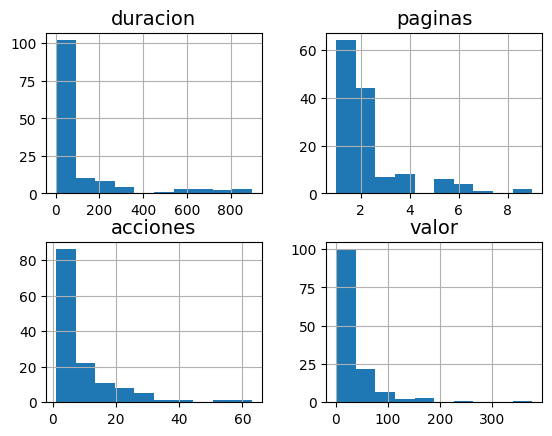

In [37]:
train_set.drop("clase", axis = 1).hist()
plt.show()

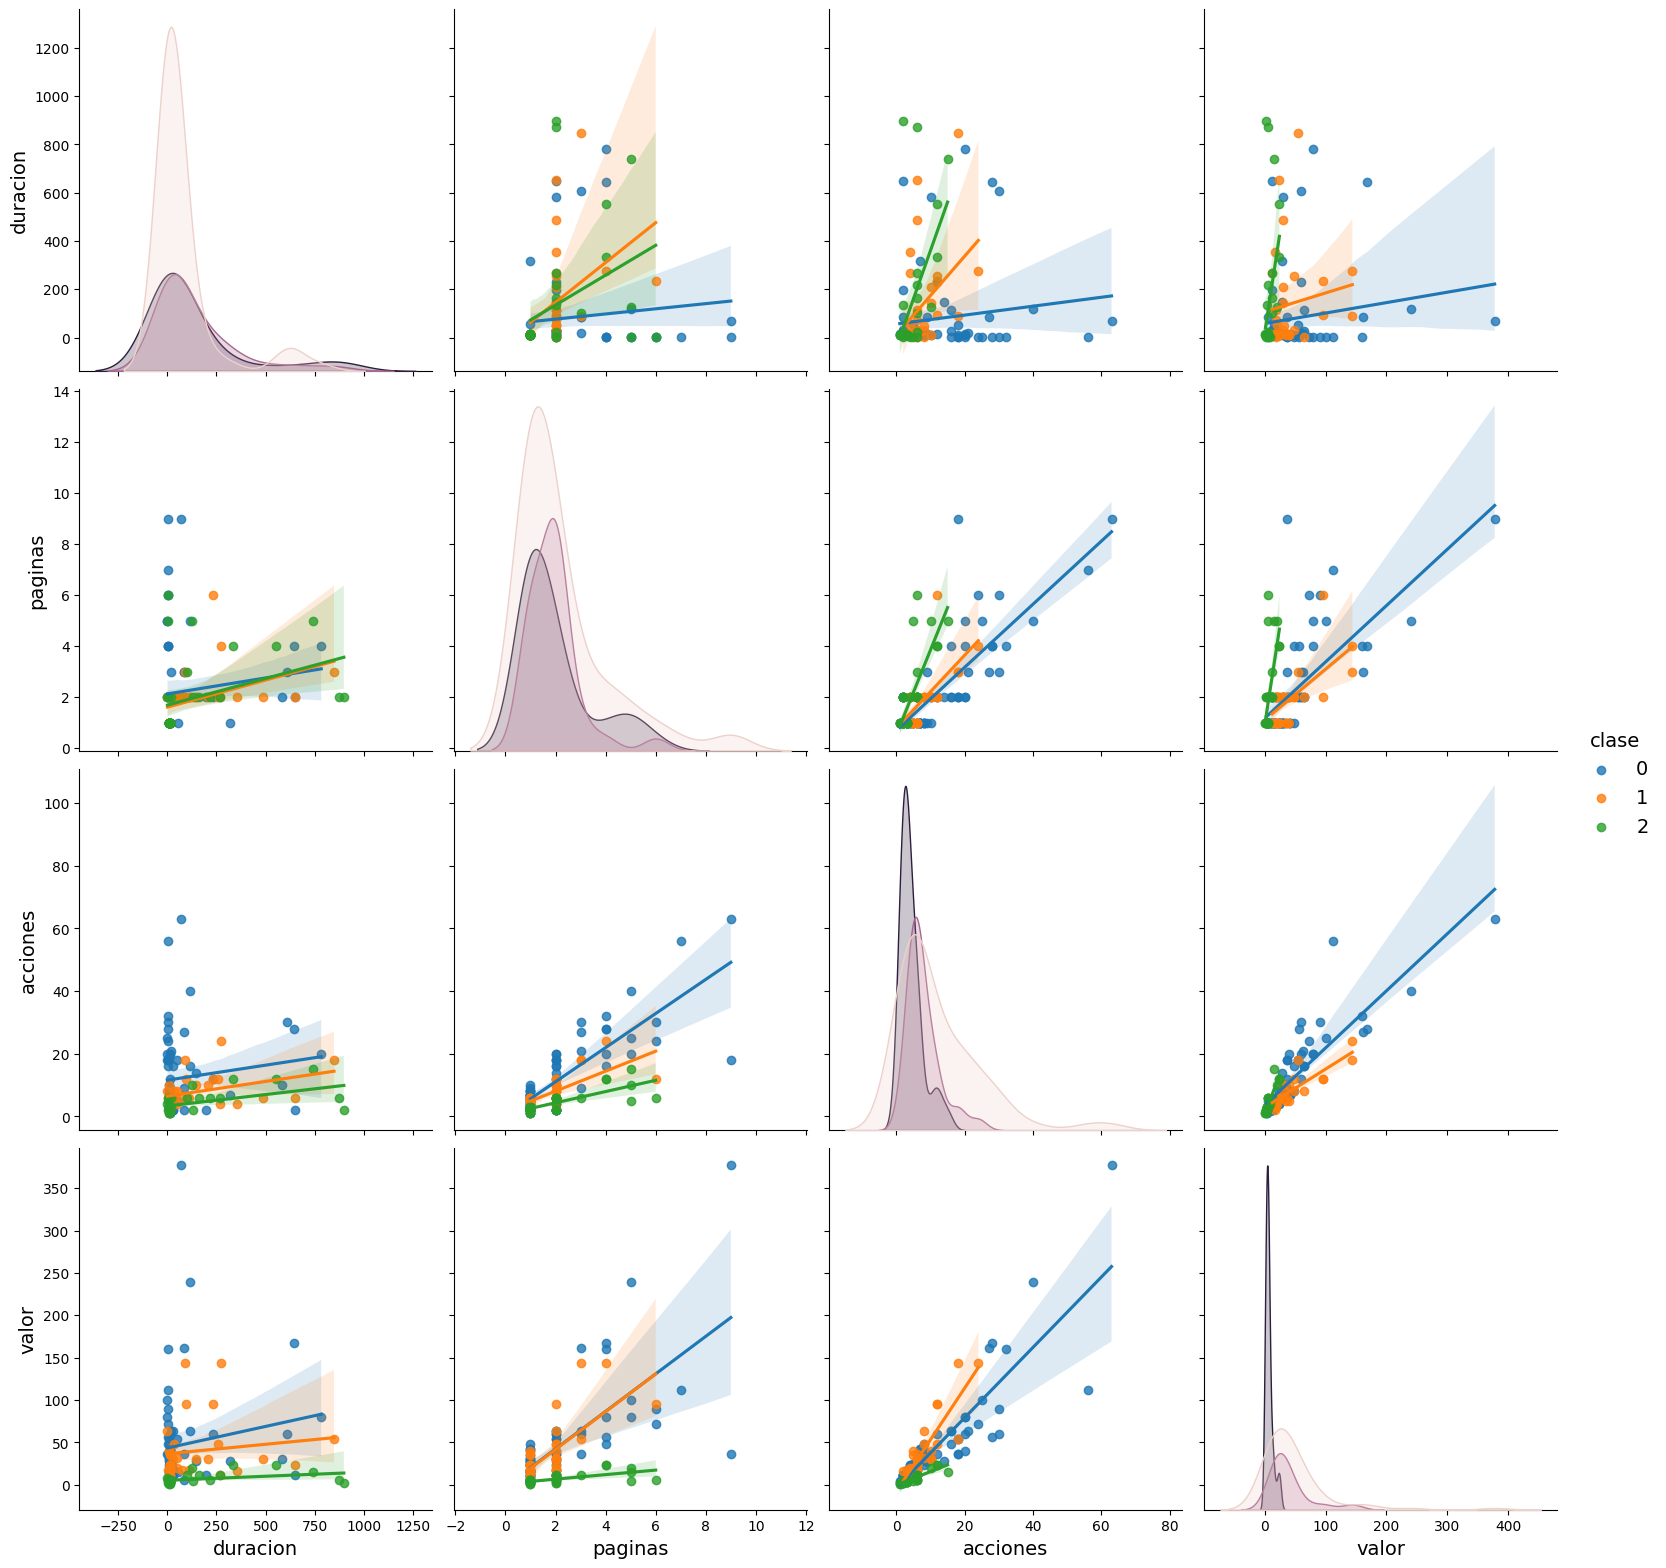

In [38]:
sns.pairplot(train_set,
            hue='clase',
            height=4,
            vars=["duracion", "paginas","acciones","valor"],
            kind='reg'); # "reg" de regresión lineal

In [39]:
features = train_set.drop("clase", axis = 1).columns.to_list()
print(features)

['duracion', 'paginas', 'acciones', 'valor']


### Procesamiento de Features

array([[<Axes: title={'center': 'duracion'}>,
        <Axes: title={'center': 'paginas'}>],
       [<Axes: title={'center': 'acciones'}>,
        <Axes: title={'center': 'valor'}>]], dtype=object)

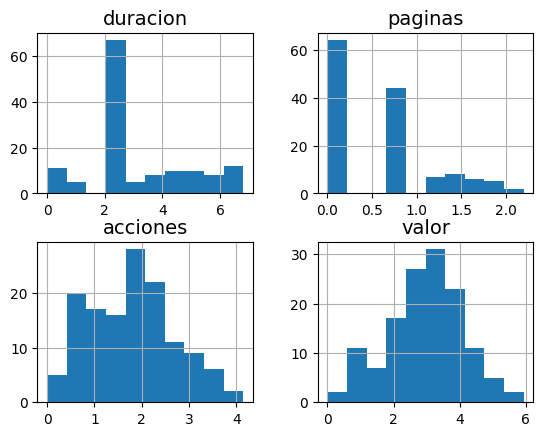

In [40]:
for col in features:
    train_set[col] = train_set[col].apply(np.log)
train_set[features].hist()

In [41]:
for col in features:
    test_set[col] = test_set[col].apply(np.log)
# Ojo ni lo mires :-), pero tienes que aplicarle las mismas transformaciones que el train.

In [42]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(train_set[features]) # Adaptamos el StandarScaler al Train, pero luego usamos el mismo en el test (porque ya la media y la desviación son las del train)
X_train = pd.DataFrame(scaler.transform(train_set[features]), columns = features)
X_test = pd.DataFrame(scaler.transform(test_set[features]), columns= features)
X_train.describe()

,duracion,paginas,acciones,valor
count,1.360000e+02,1.360000e+02,1.360000e+02,1.360000e+02
mean,-1.632681e-16,-4.571507e-17,2.416368e-16,-3.395976e-16
std,1.003697e+00,1.003697e+00,1.003697e+00,1.003697e+00
min,-1.878357e+00,-8.947527e-01,-2.004312e+00,-2.501146e+00
25%,-4.781410e-01,-8.947527e-01,-7.831545e-01,-7.258228e-01
50%,-3.805922e-01,2.695613e-01,-1.268982e-02,2.121177e-01
75%,7.491348e-01,2.695613e-01,7.577748e-01,6.482352e-01
max,2.092503e+00,2.796035e+00,2.600971e+00,2.565771e+00


In [43]:
y_train = train_set["clase"]
y_test = test_set["clase"]

### Creamos el modelo

In [46]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(max_iter=10000) 

clf.fit(X_train, y_train) # No hay que decir nada en especial, el detecta el tipo de clasificador multicategórico y aplica el one-vs-rest o one-vs-all

LogisticRegression(max_iter=10000)

Si mostramos los coeficientes o pesos del modelo veremos que en realidad ha entrenado un modelo de regresión logística para cada clase como vimos en la sesión de teoría. Ha hecho un one-vs-rest

In [47]:
clf.coef_

array([[-0.33863361, -0.28274505, -0.12062857,  1.06620115],
       [ 0.20874616, -0.29908782, -0.96460776,  1.88037632],
       [ 0.12988745,  0.58183287,  1.08523633, -2.94657748]])

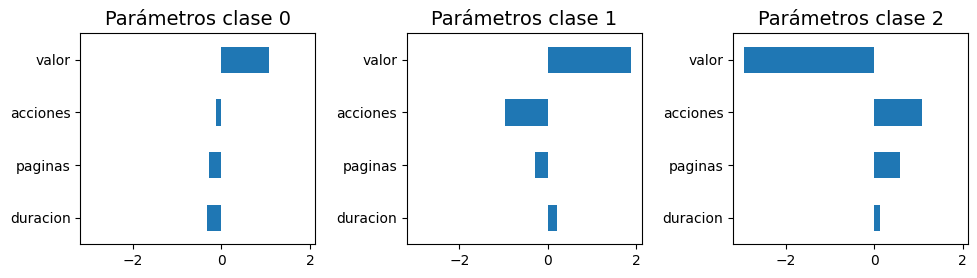

In [48]:
df_coefs = pd.DataFrame(clf.coef_, columns=X_train.columns)

fig, ax = plt.subplots(1, 3, figsize=(10, 3), sharex=True)
for i, subdf in df_coefs.iterrows():
    subdf.plot(kind="barh", ax=ax[i])
    ax[i].set_title(f"Parámetros clase {i}")

fig.tight_layout()

Ten en cuenta que estos coeficientes están aplicados sobre el logaritmo de las variables, aún así puedes ver que influye en la selección de cada clase.

Podemos ver las predicciones

In [49]:
clf.predict(X_train)

array([0, 2, 0, 0, 2, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       2, 2, 0, 1, 0, 0, 0, 2, 1, 0, 0, 0, 2, 0, 2, 0, 2, 0, 0, 0, 0, 2,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 1,
       0, 2, 2, 0, 0, 2, 0, 2, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 2, 2, 2, 0,
       0, 0, 0, 0, 0, 2, 2, 2, 2, 0, 0, 2, 0, 0, 0, 2, 0, 2, 0, 2, 0, 1,
       0, 0, 1, 1, 0, 2, 0, 0, 0, 0, 0, 2, 0, 1, 2, 0, 2, 0, 2, 2, 0, 2,
       2, 0, 2, 0])

Y las probabilidades para cada instancia, nos da un vector de tres probabilidades una para cada clase y puedes comprobar que escoge la de mayor probabilidad:

In [50]:
clf.predict_proba(X_train)

array([[0.71644988, 0.2743894 , 0.00916072],
       [0.39525661, 0.10499886, 0.49974453],
       [0.62553767, 0.33527652, 0.03918582],
       [0.67466005, 0.32187826, 0.00346169],
       [0.19053689, 0.13965596, 0.66980715],
       [0.38941522, 0.10636455, 0.50422023],
       [0.53907471, 0.45969679, 0.00122851],
       [0.75884966, 0.2158255 , 0.02532484],
       [0.46966258, 0.05475959, 0.47557783],
       [0.59096562, 0.24208018, 0.16695421],
       [0.68823716, 0.30915273, 0.00261011],
       [0.70714319, 0.28772779, 0.00512902],
       [0.74887583, 0.21917341, 0.03195076],
       [0.71324451, 0.26650969, 0.02024579],
       [0.80850583, 0.17530331, 0.01619086],
       [0.70440058, 0.21908523, 0.07651419],
       [0.60969579, 0.38175854, 0.00854567],
       [0.57631578, 0.38246988, 0.04121434],
       [0.8860096 , 0.06851385, 0.04547655],
       [0.59458687, 0.3295515 , 0.07586163],
       [0.48135544, 0.49433957, 0.02430499],
       [0.33808028, 0.52313293, 0.13878679],
       [0.

In [51]:
from sklearn.metrics import accuracy_score

acc_train = accuracy_score(y_train, clf.predict(X_train))
print(acc_train)

0.7279411764705882


En este caso vemos que el accuracy es superior a la contribución de la clase mayoritaria, no tiene mala pinta (pero recuerda que es el train). No vamos a ver el test, antes vamos a usar la validación cruzada y luego veremos las métricas para multiclase.

***

### Validamos el modelo

Usemos la validación cruzada no tanto para comparar con otros modelos, que no tenemos, sino como para adelantarnos a la evaluación con el test y de nuevo ir cogiendo hábito.

In [52]:
from sklearn import model_selection
name='Logistic Regression'
cv_results = model_selection.cross_val_score(clf, X_train, y_train, cv=5, scoring='accuracy')

msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
print(cv_results)
print(msg)

[0.64285714 0.62962963 0.66666667 0.66666667 0.77777778]
Logistic Regression: 0.676720 (0.052496)


Ya vemos que sale menor que el 72% del train. 

### Evaluación del modelo

In [53]:
from sklearn.metrics import precision_score, recall_score, accuracy_score, balanced_accuracy_score,\
                            roc_auc_score, roc_curve, precision_recall_curve, confusion_matrix, ConfusionMatrixDisplay

In [54]:
y_proba = clf.predict_proba(X_test)
y_pred = clf.predict(X_test)

#### Matriz de confusion

A mano, como un dataframe a partir de los datos que nos da el `confusion_matrix` de sklearn:

In [55]:
cm = pd.DataFrame(confusion_matrix(y_test, y_pred), index=[f"Real {i}" for i in clf.classes_], 
                  columns=[f"Predicho {i}" for i in clf.classes_])

cm

,Predicho 0,Predicho 1,Predicho 2
Real 0,14,0,3
Real 1,3,5,0
Real 2,0,0,9


Gráficamente:

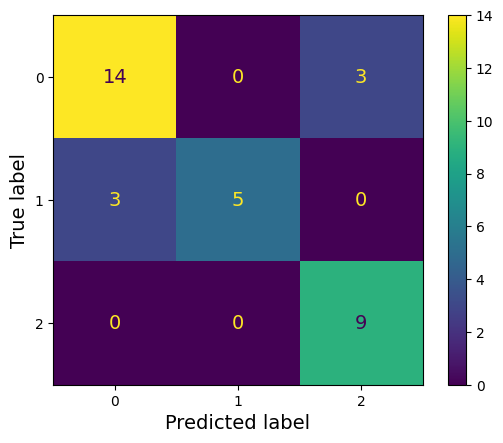

In [56]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

c:\Users\Usuario\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\_core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


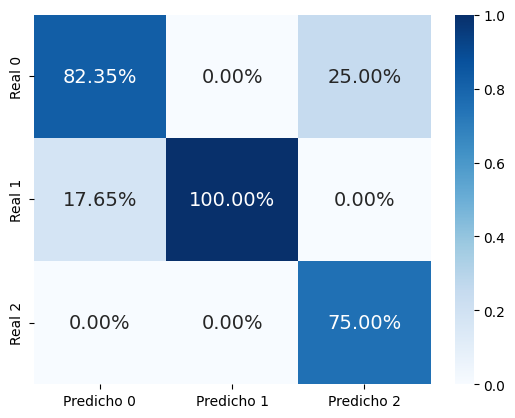

In [57]:
sns.heatmap(cm/np.sum(cm), annot=True, 
            fmt='.2%', cmap='Blues');

### Métricas MACRO y MICRO

In [58]:


micro_prec = precision_score(y_test, y_pred, average="micro")
print("MICRO PRECISION:", micro_prec)

macro_prec = precision_score(y_test, y_pred, average="macro")
print("MACRO PRECISION:", macro_prec)

micro_rec = recall_score(y_test, y_pred, average="micro")
print("MICRO RECALL:", micro_rec)

macro_rec = recall_score(y_test, y_pred, average="macro")
print("MACRO RECALL:", macro_rec)

micro_acc = accuracy_score(y_test, y_pred)
print("MICRO ACCURACY:", micro_acc)

MICRO PRECISION: 0.8235294117647058
MACRO PRECISION: 0.8578431372549019
MICRO RECALL: 0.8235294117647058
MACRO RECALL: 0.8161764705882352
MICRO ACCURACY: 0.8235294117647058


In [59]:
acierto = accuracy_score(y_test, y_pred)

error = 1 - acierto
print("Acierto:", round(acierto*100, 2), "%")
print("Error:", round(error*100, 2), "%")

Acierto: 82.35 %
Error: 17.65 %


#### Informe de Resultados

In [60]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.82      0.82        17
           1       1.00      0.62      0.77         8
           2       0.75      1.00      0.86         9

    accuracy                           0.82        34
   macro avg       0.86      0.82      0.82        34
weighted avg       0.85      0.82      0.82        34



#### Clasificación de nuevos registros

Para terminar veamos como sería la predicción para un usuario que dedica una duración de 1, ve 1 página, ejecuta 1 acción y valora con 2 el site

In [61]:
new_data = pd.DataFrame(scaler.transform(np.log(np.array([[1, 1, 1, 2]]))),columns = features)
print(new_data)
print(clf.predict_proba(new_data))
print(clf.predict(new_data))

   duracion   paginas  acciones     valor
0 -1.878357 -0.894753 -2.004312 -1.909372
[[0.13075762 0.02107934 0.84816304]]
[2]


c:\Users\Usuario\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
